## Advanced Analytics

### Looking at Chronologies

In [1]:
# Run this cell if you want to follow along 
options(warn = -1)
suppressMessages(library(neotoma2))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Bchron))

options(dplyr.summarise.inform = FALSE)

In [2]:
stara <- get_downloads(24238)
stara_chron <- chronologies(stara)

stara_chron %>% as.data.frame() %>% 
  DT::datatable(data = .)

.

HTML widgets cannot be represented in plain text (need html)

**Observations**  
There are three chronologies here.

**Objective**  
We want to build a new chronology with the function `Bchronology()` from the [`Bchron` package](https://cran.r-project.org/web/packages/Bchron/vignettes/Bchron.html). 

**How**
- Extract the chroncontrols that we have for the prior chronologies. 
- We're going to select the chronologies used for chronology `14591` as our template.  

### Extract `chroncontrols`

In [3]:
controls <- chroncontrols(stara) %>% 
  dplyr::filter(chronologyid == 14591) %>% 
  arrange(depth)

controls %>% DT::datatable(data = .)

HTML widgets cannot be represented in plain text (need html)

Let's modify directly the `controls` data.frame to provide better constraints at the core top. 

- Let's set the core top to 0 calibrated years BP;
- assume an uncertainty of 2 years;
- add a thickness of 1cm.

In [4]:
controls$chroncontrolage[1] <- 0
controls$agelimityounger[1] <- -2
controls$agelimitolder[1] <- 2
controls$thickness[1] <- 1

controls %>% DT::datatable(data = .)

HTML widgets cannot be represented in plain text (need html)

### Extract Depth & Analysis Unit IDs

Let's also get the `depth`s and `analysisunitid`s from the dataset `samples()`. 

**Why?**  
We need both `depth`s and `analysisunitid`s because a single collection unit may have multiple datasets, which may have non-overlapping depth sequences.

By adding sample ages back to a record we use the `analysisunitid` to make sure we are providing the correct assignment since depth may be specific to a single dataset.

In [5]:
# Get a two column data.frame with columns depth and analysisunitid.
# Sort the table by depth from top to bottom for "Bchronology"
predictDepths <- samples(stara) %>%
  select(depth, analysisunitid) %>% 
  unique() %>% 
  arrange(depth)

In [6]:
# Pass the values from `controls`. We're assuming the difference between
# chroncontrolage and the agelimityounger is 1 SD.

newChron <- Bchron::Bchronology(ages = controls$chroncontrolage,
                                ageSds = abs(controls$agelimityounger - 
                                               controls$chroncontrolage),
                                calCurves = c("normal", rep("intcal20", 4)),
                                positionThicknesses = controls$thickness,
                                positions = controls$depth,
                                allowOutside = TRUE,
                                ids = controls$chroncontrolid)

# Predict ages at each depth for which we have samples.  Returns a matrix.
newpredictions <- predict(newChron, predictDepths$depth)

Running Bchronology...
  |============================================================| 100%
Run completed!
  |============================================================| 100%

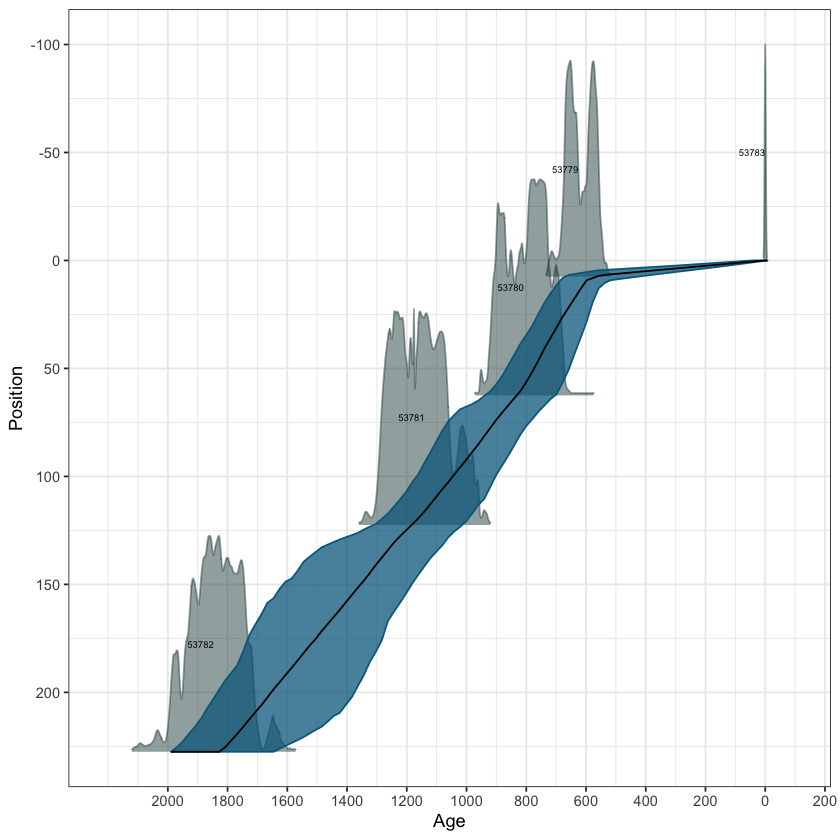

In [7]:
plot(newChron) +
  ggplot2::labs(
    xlab = "Age (cal years BP)",
    ylab = "Depth (cm)"
  )

### Creating the New `chronology` and `contact` objects

Once we have the new chronology, let's add it to the `sites` object 
Let's also make it the default chronology for any calls to `samples()`

With `set_chronology()`, we create the metadata for the new chronology.

Check the properties of chronologies using the [`chronology` table in Neotoma](https://open.neotomadb.org/dbschema/tables/chronologies.html)

In [8]:
creators <- c(set_contact(givennames = "Simon James",
                          familyname = "Goring",
                          ORCID = "0000-0002-2700-4605"),
              set_contact(givennames = "Socorro",
                          familyname = "Dominguez Vidaña",
                          ORCID = "0000-0002-7926-4935"))

In [9]:
newChronStara <- set_chronology(agemodel = "Bchron model",
                                contact = creators,
                                isdefault = 1,
                                ageboundolder = max(newpredictions),
                                ageboundyounger = min(newpredictions),
                                dateprepared = lubridate::today(),
                                modelagetype = "Calibrated radiocarbon years BP",
                                chronologyname = "Simon's example chronology",
                                chroncontrols = controls)

In [10]:
newChronStara$notes <- 'newChron <- Bchron::Bchronology(ages = controls$chroncontrolage,
                                ageSds = abs(controls$agelimityounger - 
                                               controls$chroncontrolage),
                                calCurves = c("normal", rep("intcal20", 4)),
                                positionThicknesses = controls$thickness,
                                positions = controls$depth,
                                allowOutside = TRUE,
                                ids = controls$chroncontrolid,
                                predictPositions = predictDepths)'

### Adding the `chronology` to the `collectionunit`

We now need to apply the chonology back into the `collectionunit`.

We also need to add the predicted dates into the samples for each dataset associated with the collectionunit.

So: 

1. we have a collectionunit in `stara` that is accessible at `stara[[1]]$collunits`.
2. We can use the function `add_chronology()`, which takes the chronology object and a `data.frame()` of sample ages.
3. The predicted dates associated with the new chronology need to be transferred to each `samples` object within the `collectionunit`.

The `add_chronology()` function takes the `collectionunit`, modifies it, and returns the newly updated `collectionunit`.

In [11]:
newSampleAges <- data.frame(predictDepths,
                            age = colMeans(newpredictions),
                            ageolder = colMeans(newpredictions) + 
                              apply(newpredictions, 2, sd),
                            ageyounger = colMeans(newpredictions) - 
                              apply(newpredictions, 2, sd),
                            agetype = "Calibrated radiocarbon years")

# Updating the collection unit
stara[[1]]$collunits[[1]] <- add_chronology(stara[[1]]$collunits[[1]], newChronStara, newSampleAges)

Lets take a look at how the updated `collunit` affects the age model overall. 

To pull the ages from the prior chronologies, we use the `set_default()` function to change the default chronology, and then extract ages, depths & analysisunits:

In [12]:
newages <- samples(stara) %>%
  select(depth, analysisunitid, age) %>% 
  unique() %>% 
  arrange(depth) %>% 
  mutate(agecat = "new")

stara[[1]]$collunits[[1]]$chronologies <- set_default(stara[[1]]$collunits[[1]]$chronologies,
                                                      14591)  
plotforages <- samples(stara) %>%
  select(depth, analysisunitid, age) %>% 
  unique() %>% 
  arrange(depth) %>% 
  mutate(agecat = "old") %>% 
  bind_rows(newages)

### Differences

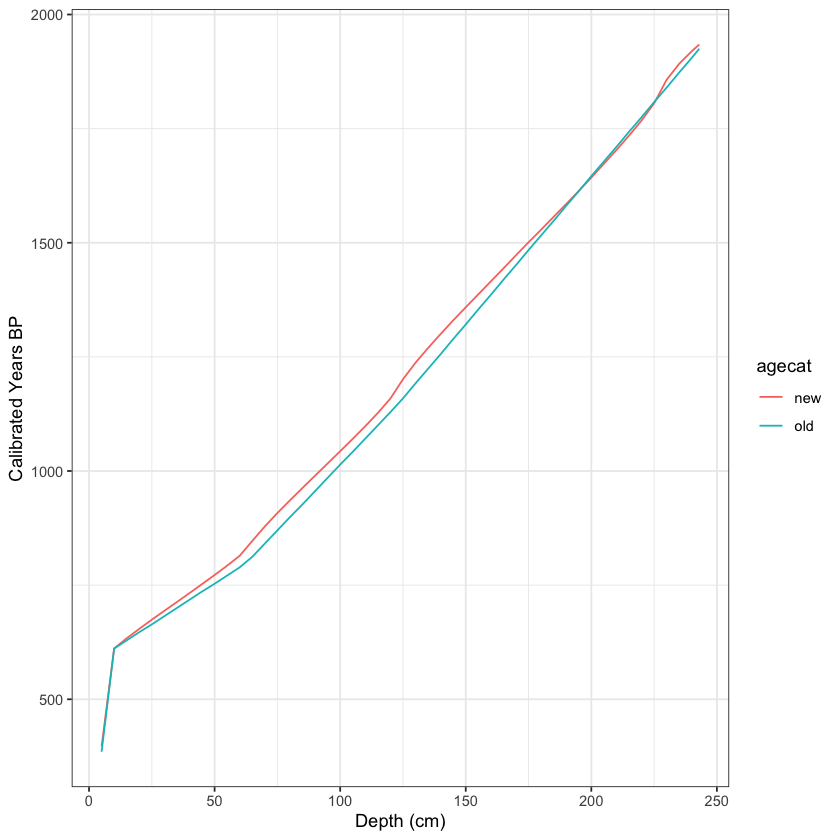

In [13]:
ggplot(plotforages, aes(x = depth, y = age)) +
  geom_path(aes(color = agecat)) +
  theme_bw() +
  xlab("Depth (cm)") +
  ylab("Calibrated Years BP")